<a href="https://colab.research.google.com/github/omrzcs2-ux/Group-A-DLI-Assignment/blob/main/Omar(InceptionResnetV2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Models Training on Transformed Edge_IIOTset Dataset**

In [2]:
!pip install -q Keras-Applications

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [3]:
# ================== IMPORT LIBRARIES ==================
import os, glob, zipfile, time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import callbacks, optimizers

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


**Generate Training and Test Images**

In [4]:
# ================== UNZIP DATASETS ==================
# Put your uploaded zips in /content or adjust these paths:
train_zip = "/content/train_A.zip"
test_zip  = "/content/test_A.zip"

# Where to extract
train_dir = "/content/train_A"
test_dir  = "/content/test_A"

# Extract only if not already extracted
if (os.path.exists(train_zip)) and (not os.path.exists(train_dir)):
    with zipfile.ZipFile(train_zip, 'r') as z:
        z.extractall("/content")
if (os.path.exists(test_zip)) and (not os.path.exists(test_dir)):
    with zipfile.ZipFile(test_zip, 'r') as z:
        z.extractall("/content")

print("Train root:", train_dir, "-> subfolders:", os.listdir(train_dir)[:5] if os.path.exists(train_dir) else "MISSING")
print("Test  root:", test_dir,  "-> subfolders:", os.listdir(test_dir)[:5]  if os.path.exists(test_dir)  else "MISSING")

Train root: /content/train_A -> subfolders: ['MITM', 'XSS', 'Ransomware', 'DDoS_ICMP', 'Port_Scanning']
Test  root: /content/test_A -> subfolders: ['MITM', 'XSS', 'Ransomware', 'DDoS_ICMP', 'Port_Scanning']


In [5]:
# ================== DATA GENERATORS ==================
TARGET_SIZE = (224, 224)
INPUT_SIZE  = (224, 224, 3)
BATCHSIZE   = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=TARGET_SIZE, batch_size=BATCHSIZE, class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir, target_size=TARGET_SIZE, batch_size=BATCHSIZE, class_mode='categorical')

num_class = train_generator.num_classes
print("Detected classes:", num_class, train_generator.class_indices)

Found 5369 images belonging to 15 classes.
Found 1342 images belonging to 15 classes.
Detected classes: 15 {'Backdoor': 0, 'DDoS_HTTP': 1, 'DDoS_ICMP': 2, 'DDoS_TCP': 3, 'DDoS_UDP': 4, 'Fingerprinting': 5, 'MITM': 6, 'Normal': 7, 'Password': 8, 'Port_Scanning': 9, 'Ransomware': 10, 'SQL_injection': 11, 'Uploading': 12, 'Vulnerability_scanner': 13, 'XSS': 14}


# **Model 6: InceptionResnet V2**

In [ ]:
# ================== BUILD & TRAIN MODEL ==================
input_shape = INPUT_SIZE
epochs      = 2
savepath    = '/content/inceptionresnetv2.h5'

# Base model
base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze first ~540 layers as in your code
for layer in base.layers[:540]:
    layer.trainable = False
for layer in base.layers[540:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(num_class, activation='softmax')(x)

model = Model(base.input, out, name='inception_resnet_v2')

opt = optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

ckpt = callbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy',
                                 verbose=1, save_best_only=True, mode='auto')

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[ckpt]
)

Epoch 1/2
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8433 - loss: 0.5258 
Epoch 1: val_accuracy improved from -inf to 0.01937, saving model to /content/inceptionresnetv2.h5


168/168 ━━━━━━━━━━━━━━━━━━━━ 2408s 14s/step - accuracy: 0.8436 - loss: 0.5245 - val_accuracy: 0.0194 - val_loss: 116.6029
Epoch 2/2
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9402 - loss: 0.1676 
Epoch 2: val_accuracy improved from 0.01937 to 0.92101, saving model to /content/inceptionresnetv2.h5


168/168 ━━━━━━━━━━━━━━━━━━━━ 2349s 14s/step - accuracy: 0.9402 - loss: 0.1675 - val_accuracy: 0.9210 - val_loss: 0.3176


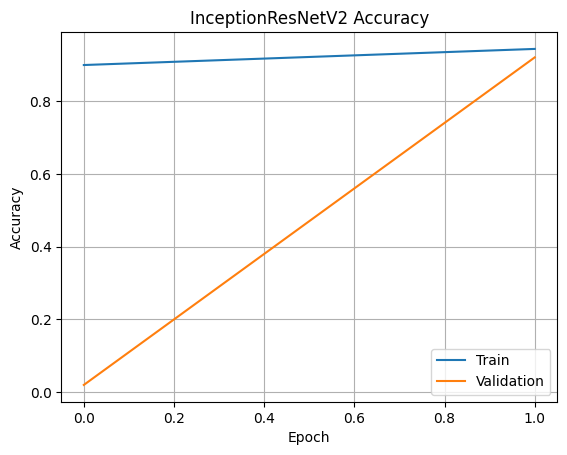

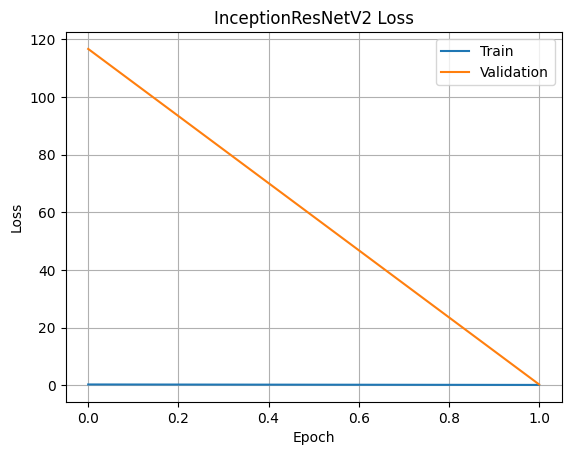

In [ ]:
# ================== PLOTS ==================
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('InceptionResNetV2 Accuracy', fontsize=12)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionResNetV2 Loss', fontsize=12)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# ================== PREDICTION ON TEST IMAGES ==================
%%time
# Collect all test images (inside class subfolders)
test_images = glob.glob(test_dir + "/*/*")

print("Total test images:", len(test_images))

predict = []
true_labels = []

# Reverse mapping from indices to class names
class_indices = train_generator.class_indices
idx2class = {v: k for k, v in class_indices.items()}

for img_path in test_images:
    # True label from folder name
    true_class = os.path.basename(os.path.dirname(img_path))
    true_labels.append(true_class)

    # Load + preprocess
    img = Image.open(img_path).resize((224,224))
    img = np.array(img)/255.0
    img = np.expand_dims(img, axis=0)

    # Prediction
    preds = model.predict(img, verbose=0)
    pred_class = idx2class[np.argmax(preds)]
    predict.append(pred_class)

print("✅ Prediction done on", len(predict), "images")

Total test images: 1342
✅ Prediction done on 1342 images
CPU times: user 12min 15s, sys: 15.6 s, total: 12min 30s
Wall time: 8min 45s


Accuracy            : 0.9210
Precision (weighted): 0.9028
Recall    (weighted): 0.9210
F1-score  (weighted): 0.9057
Precision (macro)   : 0.5639
Recall    (macro)   : 0.6428
F1-score  (macro)   : 0.5858

Per-class report:

                       precision    recall  f1-score   support

             Backdoor     1.0000    0.7647    0.8667        17
            DDoS_HTTP     0.4648    1.0000    0.6346        33
            DDoS_ICMP     1.0000    1.0000    1.0000        40
             DDoS_TCP     1.0000    1.0000    1.0000        24
             DDoS_UDP     1.0000    1.0000    1.0000        91
       Fingerprinting     0.0000    0.0000    0.0000         7
                 MITM     0.0000    0.0000    0.0000         3
               Normal     1.0000    0.9798    0.9898       940
             Password     0.0000    0.0000    0.0000        42
        Port_Scanning     0.0000    0.0000    0.0000        20
           Ransomware     0.0000    0.0000    0.0000         7
        SQL_injectio

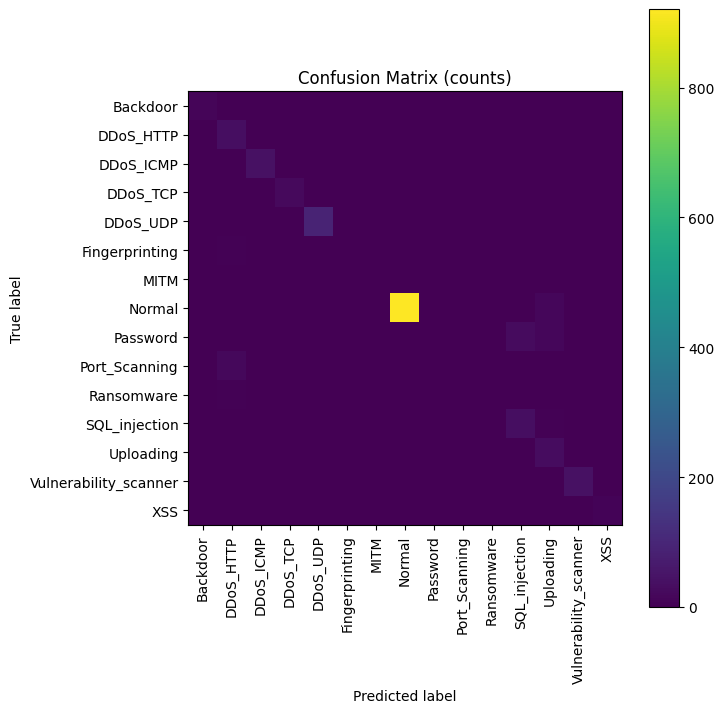

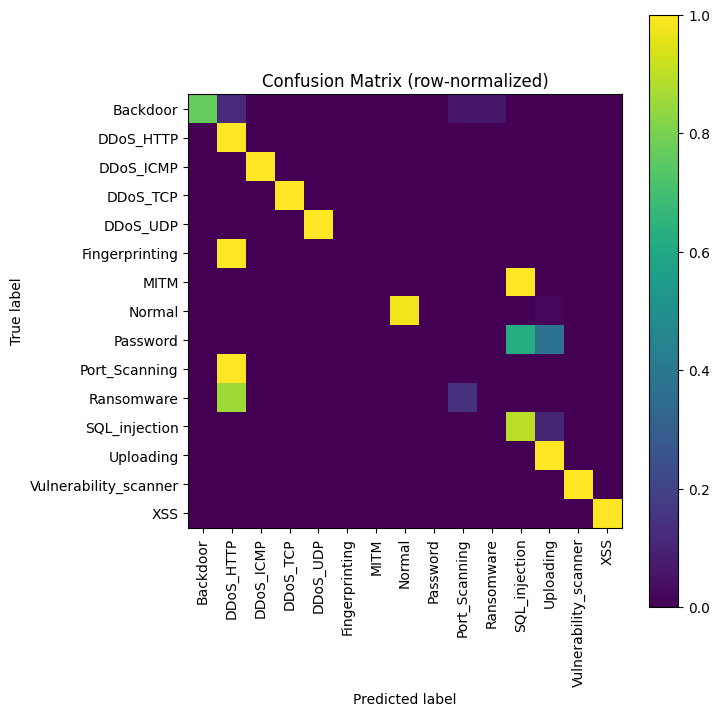

In [ ]:
# ===== EVALUATION (uses `predict`, `true_labels`, `class_indices`) =====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Sanity check
assert len(true_labels) == len(predict), f"Length mismatch: true={len(true_labels)} pred={len(predict)}"

# Class name lists
train_class_names = list(class_indices.keys())
all_class_names = sorted(set(train_class_names) | set(true_labels) | set(predict))  # robust to any mismatch

# Overall metrics
acc   = accuracy_score(true_labels, predict)
precW = precision_score(true_labels, predict, average='weighted', zero_division=0)
recW  = recall_score(true_labels, predict, average='weighted', zero_division=0)
f1W   = f1_score(true_labels, predict, average='weighted', zero_division=0)
precM = precision_score(true_labels, predict, average='macro', zero_division=0)
recM  = recall_score(true_labels, predict, average='macro', zero_division=0)
f1M   = f1_score(true_labels, predict, average='macro', zero_division=0)

print(f"Accuracy            : {acc:.4f}")
print(f"Precision (weighted): {precW:.4f}")
print(f"Recall    (weighted): {recW:.4f}")
print(f"F1-score  (weighted): {f1W:.4f}")
print(f"Precision (macro)   : {precM:.4f}")
print(f"Recall    (macro)   : {recM:.4f}")
print(f"F1-score  (macro)   : {f1M:.4f}")

# Per-class report
print("\nPer-class report:\n")
print(classification_report(true_labels, predict,
                            labels=all_class_names,
                            target_names=all_class_names,
                            zero_division=0,
                            digits=4))

# Confusion matrix (counts)
cm = confusion_matrix(true_labels, predict, labels=all_class_names)

fig_w = max(6, len(all_class_names) * 0.5)
fig_h = max(5, len(all_class_names) * 0.5)

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(all_class_names)),
    yticks=np.arange(len(all_class_names)),
    xticklabels=all_class_names,
    yticklabels=all_class_names,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix (counts)'
)
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# Confusion matrix (row-normalized)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
im = ax.imshow(cm_norm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(all_class_names)),
    yticks=np.arange(len(all_class_names)),
    xticklabels=all_class_names,
    yticklabels=all_class_names,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix (row-normalized)'
)
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

Comparison of Results (Your Run vs. Paper)

+--------------------------+----------+----------------------+-------------------+---------------+-------------------+----------------+------------+----------+
| Source / Model           | Accuracy | Precision (weighted) | Recall (weighted) | F1 (weighted) | Precision (macro) | Recall (macro) | F1 (macro) | CK score |
+--------------------------+----------+----------------------+-------------------+---------------+-------------------+----------------+------------+----------+
| Your InceptionResNetV2   | 0.9210   | 0.9028               | 0.9210            | 0.9057        | 0.5639            | 0.6428         | 0.5858     | —        |
| Paper: InceptionResNetV2 | 0.8837   | 0.8435               | 0.8837            | 0.8522        | —                 | —              | —          | 0.7665   |
+--------------------------+----------+----------------------+-------------------+---------------+-------------------+----------------+------------+--------

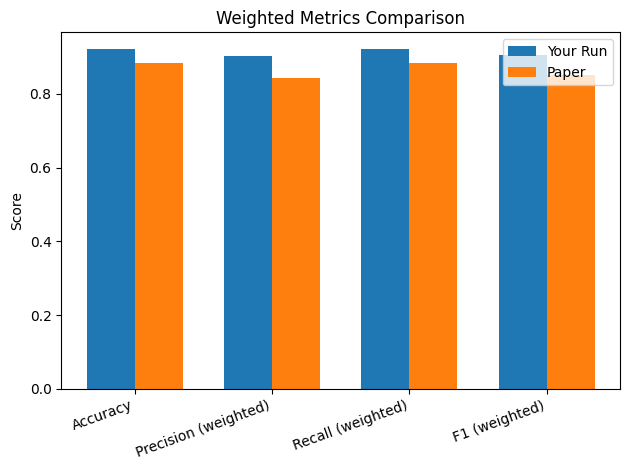

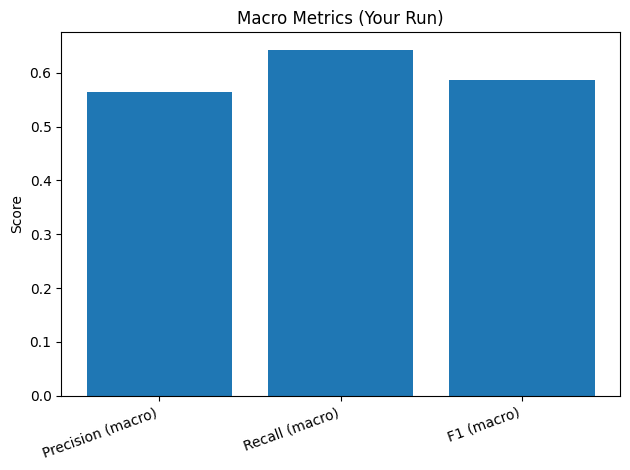

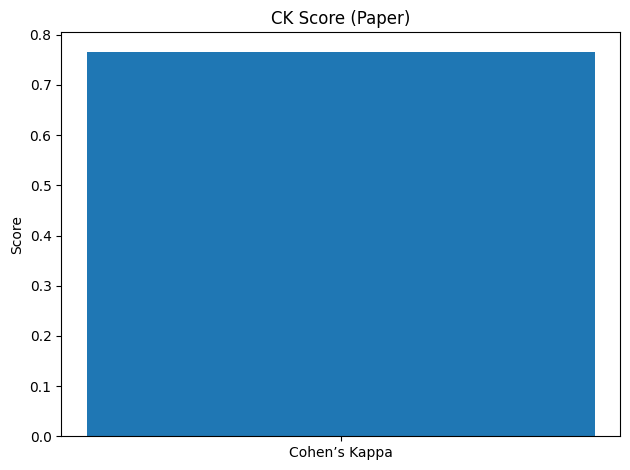


Notes:
 - Macro metrics were not reported in the paper; shown only for your run.
 - CK score (Cohen’s Kappa) was reported only in the paper; not available for your run.


In [10]:
# Text table + graphs: Your results vs Paper (InceptionResNetV2)

import numpy as np
import matplotlib.pyplot as plt

# ----- INPUT METRICS -----
your = {
    "Accuracy": 0.9210,
    "Precision (weighted)": 0.9028,
    "Recall (weighted)": 0.9210,
    "F1 (weighted)": 0.9057,
    "Precision (macro)": 0.5639,
    "Recall (macro)": 0.6428,
    "F1 (macro)": 0.5858,
    # CK score not reported for your run
}

paper = {
    "Accuracy": 0.8837,
    "Precision (weighted)": 0.8435,
    "Recall (weighted)": 0.8837,
    "F1 (weighted)": 0.8522,
    "CK score": 0.7665,
    # macro metrics not reported in paper
}

# ----- TEXT TABLE -----
title = "Comparison of Results (Your Run vs. Paper)"
headers = [
    "Source / Model",
    "Accuracy",
    "Precision (weighted)",
    "Recall (weighted)",
    "F1 (weighted)",
    "Precision (macro)",
    "Recall (macro)",
    "F1 (macro)",
    "CK score",
]

rows = [
    [
        "Your InceptionResNetV2",
        f"{your.get('Accuracy','—'):.4f}",
        f"{your.get('Precision (weighted)','—'):.4f}",
        f"{your.get('Recall (weighted)','—'):.4f}",
        f"{your.get('F1 (weighted)','—'):.4f}",
        f"{your.get('Precision (macro)','—'):.4f}",
        f"{your.get('Recall (macro)','—'):.4f}",
        f"{your.get('F1 (macro)','—'):.4f}",
        "—",
    ],
    [
        "Paper: InceptionResNetV2",
        f"{paper.get('Accuracy','—'):.4f}",
        f"{paper.get('Precision (weighted)','—'):.4f}",
        f"{paper.get('Recall (weighted)','—'):.4f}",
        f"{paper.get('F1 (weighted)','—'):.4f}",
        "—",
        "—",
        "—",
        f"{paper.get('CK score','—'):.4f}",
    ],
]

# helper to print a neat text table
def build_table(headers, rows):
    # coerce non-strings to strings
    rows_str = [[str(c) for c in r] for r in rows]
    col_widths = [len(h) for h in headers]
    for r in rows_str:
        for i, cell in enumerate(r):
            col_widths[i] = max(col_widths[i], len(cell))

    def hline(sep_left="+", sep_mid="+", sep_right="+", fill="-"):
        return sep_left + sep_mid.join(fill * (w + 2) for w in col_widths) + sep_right

    def fmt_row(items):
        return "| " + " | ".join(str(c).ljust(w) for c, w in zip(items, col_widths)) + " |"

    print(title)
    print()
    print(hline())
    print(fmt_row(headers))
    print(hline())
    for r in rows_str:
        print(fmt_row(r))
    print(hline())

build_table(headers, rows)

# ----- GRAPHS -----
# 1) Weighted metrics comparison (both have values)
weighted_keys = ["Accuracy", "Precision (weighted)", "Recall (weighted)", "F1 (weighted)"]
your_w = [your[k] for k in weighted_keys]
paper_w = [paper[k] for k in weighted_keys]

x = np.arange(len(weighted_keys))
w = 0.35

plt.figure()
plt.bar(x - w/2, your_w, width=w, label="Your Run")
plt.bar(x + w/2, paper_w, width=w, label="Paper")
plt.title("Weighted Metrics Comparison")
plt.xticks(ticks=x, labels=weighted_keys, rotation=20, ha="right")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Macro metrics (only your run reported)
macro_keys = ["Precision (macro)", "Recall (macro)", "F1 (macro)"]
your_m = [your[k] for k in macro_keys]

plt.figure()
plt.bar(np.arange(len(macro_keys)), your_m)
plt.title("Macro Metrics (Your Run)")
plt.xticks(ticks=np.arange(len(macro_keys)), labels=macro_keys, rotation=20, ha="right")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# 3) CK score (only paper reported)
plt.figure()
plt.bar([0], [paper["CK score"]])
plt.title("CK Score (Paper)")
plt.xticks([0], ["Cohen’s Kappa"])
plt.ylabel("Score")
plt.tight_layout()
plt.show()

print("\nNotes:")
print(" - Macro metrics were not reported in the paper; shown only for your run.")
print(" - CK score (Cohen’s Kappa) was reported only in the paper; not available for your run.")
